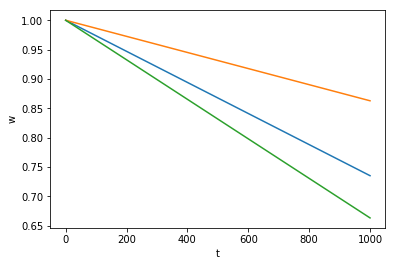

In [45]:
from math import sin
from math import cos
from math import pi
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

# Q — Euler angles matrix
def Q_matr(psi, theta, phi):
    return np.array([[cos(psi)*cos(theta), cos(psi)*sin(phi)*sin(theta) - cos(phi)*sin(psi), sin(phi)*sin(psi) + cos(phi)*cos(psi)*sin(theta)], 
                     [cos(theta)*sin(psi), cos(phi)*cos(psi) + sin(phi)*sin(psi)*sin(theta), cos(phi)*sin(psi)*sin(theta) - cos(psi)*sin(phi)], 
                     [-sin(theta), cos(theta)*sin(phi), cos(phi)*cos(theta)]])

# P = Q_desired^T * Q -> I — goal of control
def P_matr(psi, theta, phi):
    return Q_des.T * Q_matr(psi, theta, phi)

# Omega — scew symmetric matrix made from angular velocities in the body frame
def Omega_matr(p, q, r):
    return vec_to_scew(np.array([p,q,r]))

# Theta — matrix that contains components of dot Omega matrix
def Theta_matr(p, q, r):
    return vec_to_scew(np.array([((I_y - I_z)/I_x) * q * r, ((I_z - I_x)/ I_y) * p * r, ((I_x - I_y)/ I_z) * p * q]))

# Tau — matrix of controls, solution of matrix equation 
def Tau_norm_matr(psi, theta, phi, p, q, r, lmbd):
    P = P_matr(psi, theta, phi)
    Theta = Theta_matr(psi, theta, phi)
    Omega = Omega_matr(p, q, r)
    
    A = np.array([[P[1][1] + P[2][2], -P[1][0], -P[2][0]], 
                  [-P[0][1], P[0][0] + P[2][2], -P[2][1]], 
                  [-P[0][2], -P[1][2], P[0][0] + P[1][1]]])
    
    B = -P @ Omega @ Omega - P @ Theta + Omega @ Omega @ P.T - Omega @ P.T - 2 * lmbd * (P @ Omega + Omega @ P.T) - (lmbd ** 2) * (P - P.T)
    b = scew_to_vec(B)
    
    Tau_norm = np.linalg.solve(A, b)
    return Tau_norm @ I_matr

# Transformation of vector to scew-symmetric matrix
def vec_to_scew(vec):
    return np.array([[0, -vec[2], vec[1]],
                     [vec[2], 0, -vec[0]],
                     [-vec[1], vec[0], 0]])

# Transformation of scew-symmetric matrix to vector
def scew_to_vec(matr):
    return np.array([matr[2][1], matr[0][2], matr[1][0]])


# Quadrotor constants
I_x = I_y = 7.5 * (10**(-3))
I_z  = 1.3 * (10**(-2))
m = 1
b = 3.13 * (10**(-5))
d = 7.5 * (10**(-7))
l = 0.25
I_vec = np.array([I_x, I_y, I_z])               # Inertia moment vector
I_matr = np.eye(3) * I_vec                      # Inertia moment matrix 

Q_des = Q_matr(0, 0, 0)                         # Desired Q

lmbd = 0.1                                      # Desired rate of convergence

psi_0 = pi/8; theta_0 = pi/8; phi_0 = pi/8      # Initial angles
p_0 = 1; q_0 = 1; r_0 = 1                       # Initial angular velocities in the body frame



# Solving ODE

Tau_norm = Tau_norm_matr(psi_0, theta_0, phi_0, p_0, q_0, r_0, lmbd)
# t_span = np.linspace(0,5,10)
t_span = [0, 1000]
w_0 = np.array([p_0, q_0, r_0])                 # Initial conditions

# Right-hand side of the ODE system
def dw_dt(w, t):
    return  Tau_norm - np.cross(I_vec, w) @ np.linalg.inv(I_matr)

# dot_w = spi.solve_ivp(dw_dt, t_span, w_0)
dot_w = spi.odeint(dw_dt, w_0, t_span)

plt.xlabel("t")
plt.ylabel("w")
# plt.plot(dot_w.y, t_span)
plt.plot(t_span, dot_w)
